In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../../..'))

if module_path not in sys.path:
    print(f"Adding [{module_path}] to sys.path")
    sys.path.append(module_path)

# Comparing ALCS Latent-Learning capabilities

Approach to compare *latent-learning* capabilities of various ALCS systems.

The following aspects will be compared:

- ability learn consequences of performing action in certain states (build accurate internal model of the environment),
- ability to generalize,
- size of internal classifier population,
- relative operation time

In [2]:
import pathlib

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from lcs import Perception

import gym
# noinspection PyUnresolvedReferences
import gym_yacs_simple_maze
# noinspection PyUnresolvedReferences
import gym_corridor
# noinspection PyUnresolvedReferences
import gym_grid
# noinspection PyUnresolvedReferences
import gym_multiplexer

# Logger
# import logging
# logging.basicConfig(level=logging.DEBUG)

# Common plot settings
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['lines.linewidth'] = 2

# Gecco submission settings
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2

In [3]:
from notebooks import get_from_cache_or_run

# Import common utils code
%run utils/experiments.py
%run utils/plotting.py
%run utils/stats.py
%run utils/bayes.py

In [4]:
cache_prefix = f'{pathlib.Path().absolute()}/cache/'
cache_prefix

'/home/arc/Projects/pwr/pyalcs-experiments/notebooks/publications/latent-learning-for-anticipatory-classifier-systems-in-discretized-real-valued-environments/cache/'

In [5]:
agents = ['acs', 'acs2', 'acs2_oiq', 'acs2_ga', 'acs2_ga_oiq', 'yacs', 'dynaq']
metrics = ['knowledge', 'generalization', 'population', 'time']

# Environments
This section presents the multi-step environments that were used in experiments.

1. [Simple Maze](#Simple-Maze) - Simpler maze variant with limited perception and available actions

Discretized real-valued.

2. [Corridor](#Corridor) - one dimension and two actions are available. The agent is checked is optimal number of classifiers is created
3. [Grid](#Grid) - two dimensions and four actions.

Maybe (todo)

4. Maze4 / Maze6 - More advanced mazes (bigger perception and available actions)

## Simple Maze
In each trial the agent is placed in __S__ tile. It can perceive 4 values (N, E, S and W) and can move in each cardinal direction. The trial ends when tile **F** is reached.

![simple-maze](img/simple-maze-env.png)

Minimal number of classifiers to model the environment is __20__. The number of _"fully-specialized"_ classifiers is **32**.

In [6]:
simple_maze = gym.make('SimpleMaze-v0')
simple_maze_perceptions = simple_maze.env.PERCEPTIONS
simple_maze_transitions = simple_maze.env.TRANSITIONS

# LCS helpers
def simple_maze_knowledge(pop, env):
    all_transitions = 0
    nr_correct = 0

    for s0, action_states in env.env.TRANSITIONS.items():
        for action_state in action_states:
            all_transitions += 1

            action = action_state.action.value
            s1 = action_state.state

            p0 = env.env._perception(s0)
            p1 = env.env._perception(s1)

            if any([True for cl in pop if cl.predicts_successfully(p0, action, p1)]):
                nr_correct += 1

    return nr_correct / all_transitions


def simple_maze_metrics_collect(agent, env):
    population = agent.population
    return {
        'pop': len(population),
        'knowledge': simple_maze_knowledge(population, env),
        'generalization': generalization_score(population)
    }


# DynaQ helpers
def simple_maze_perception_to_int(p0):
    p0m = list(map(int, p0))
    return list(simple_maze_perceptions.keys())[list(simple_maze_perceptions.values()).index(p0m)]


def simple_maze_knowledge_calculator(model, env):
    all_transitions = 0
    nr_correct = 0

    for s0, moves in simple_maze_transitions.items():
        for move in moves:
            a = move.action.value
            s1 = move.state

            all_transitions += 1
            if s0 in model and a in model[s0] and model[s0][a][0] == s1:
                nr_correct += 1

    return nr_correct / all_transitions

In [7]:
%%time

common_params = {
    'env': simple_maze,
    'observation_wrapper': None,
    'classifier_length': 4,
    'possible_actions': 4,
    'learning_rate': 0.1,
    'metrics_trial_freq': 1,
    'metrics_fcn': simple_maze_metrics_collect,
    'trials': 250
}

yacs_params = {
    'trace_length': 3,
    'estimate_expected_improvements': False,
    'feature_possible_values': [{'0', '1'}] * 4
}

dynaq_params = {
    'q_init': np.zeros((len(simple_maze_perceptions), 4)),
    'model_init': {},
    'perception_to_state_mapper': simple_maze_perception_to_int,
    'knowledge_fcn': simple_maze_knowledge_calculator,
    'epsilon': 0.5
}

simple_maze_metrics = get_from_cache_or_run(
    f'{cache_prefix}/SimpleMaze5.dill',
    lambda: execute_experiments(lambda: run_experiment_parallel(common_params,
                                                                acs_params={},
                                                                acs2_params={'do_ga': False, 'initial_q': 0.5},
                                                                acs2_oiq_params={'do_ga': False, 'initial_q': 0.8},
                                                                acs2_ga_params={'do_ga': True, 'initial_q': 0.5},
                                                                acs2_ga_oiq_params={'do_ga': True, 'initial_q': 0.8},
                                                                yacs_params=yacs_params,
                                                                dynaq_params=dynaq_params),
                                n=50))


CPU times: user 34 ms, sys: 451 µs, total: 34.5 ms
Wall time: 34.2 ms


In [8]:
simple_maze_metrics[0].head()

time  knowledge  population  generalization  trial_steps
agent trial                                                              
acs   1      0.003531   0.466667        11.0        0.681818         11.0
      2      0.002039   0.600000        14.0        0.553571         20.0
      3      0.003140   0.666667        15.0        0.550000         34.0
      4      0.004096   0.866667        18.0        0.555556         42.0
      5      0.050725   1.000000        22.0        0.511364        308.0

/home/arc/Projects/pwr/pyalcs-experiments/notebooks/publications/latent-learning-for-anticipatory-classifier-systems-in-discretized-real-valued-environments/utils/plotting.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 1].set_xticklabels(labels, rotation=60)


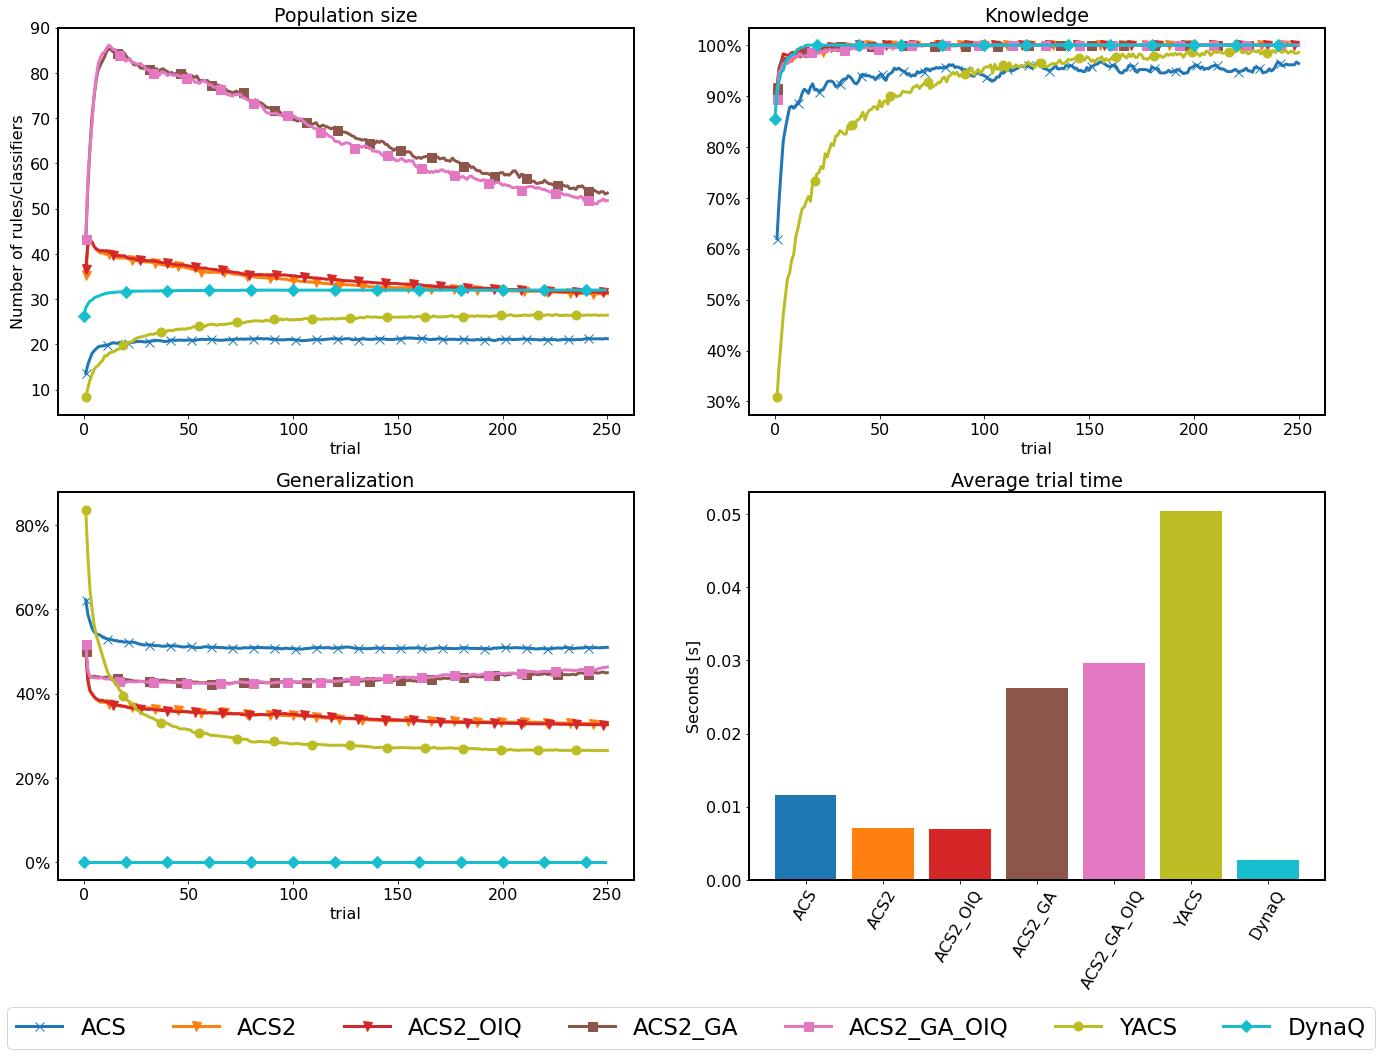

In [9]:
%run utils/plotting.py

# average experiments
simple_maze_metrics_averaged_df = pd.concat(simple_maze_metrics).groupby(['agent', 'trial']).mean()

plot_comparison(simple_maze_metrics_averaged_df)
plt.savefig('plots/simple-maze.pdf', transparent=False, bbox_inches='tight')

## Corridor

![corridor](img/corridor-env.png)

In [10]:
corridor = gym.make('corridor-20-v0')


# LCS helpers
def corridor_knowledge(pop, env):
    transitions = env.env.get_transitions()
    reliable = [c for c in pop if c.is_reliable()]
    nr_correct = 0

    for start, action, end in transitions:
        p0 = Perception((str(start),))
        p1 = Perception((str(end),))

        if any(
                [True for cl in reliable if cl.predicts_successfully(p0, action, p1)]):
            nr_correct += 1

    return nr_correct / len(transitions)


def corridor_metrics_collect(agent, env):
    population = agent.population
    return {
        'pop': len(population),
        'knowledge': corridor_knowledge(population, env),
        'generalization': generalization_score(population)
    }


class CorridorObservationWrapper(gym.ObservationWrapper):
    def observation(self, observation):
        return observation,


# DynaQ helpers
def dynaq_corridor_knowledge_calculator(model, env):
    transitions = env.env.get_transitions()
    nr_correct = 0

    for (s0, a, s1) in transitions:
        if s0 in model and a in model[s0] and model[s0][a][0] == s1:
            nr_correct += 1

    return nr_correct / len(transitions)

In [11]:
%%time

common_params = {
    'env': corridor,
    'observation_wrapper': CorridorObservationWrapper,
    'classifier_length': 1,
    'possible_actions': 2,
    'learning_rate': 0.1,
    'metrics_trial_freq': 1,
    'metrics_fcn': corridor_metrics_collect,
    'trials': 300
}

yacs_params = {
    'trace_length': 3,
    'estimate_expected_improvements': False,
    'feature_possible_values': [set(str(i) for i in range(19)), ]
}

dynaq_params = {
    'q_init': np.zeros((corridor.env.observation_space.n, 2)),
    'model_init': {},
    'perception_to_state_mapper': lambda p: int(p),
    'knowledge_fcn': dynaq_corridor_knowledge_calculator,
    'epsilon': 0.5
}

corridor_metrics = get_from_cache_or_run(
    f'{cache_prefix}/Corridor1.dill',
    lambda: execute_experiments(lambda: run_experiment_parallel(common_params,
                                                                acs_params={},
                                                                acs2_params={'do_ga': False, 'initial_q': 0.5},
                                                                acs2_oiq_params={'do_ga': False, 'initial_q': 0.8},
                                                                acs2_ga_params={'do_ga': True, 'initial_q': 0.5},
                                                                acs2_ga_oiq_params={'do_ga': True, 'initial_q': 0.8},
                                                                yacs_params=yacs_params,
                                                                dynaq_params=dynaq_params),
                                n=50))

CPU times: user 28.4 ms, sys: 4.16 ms, total: 32.6 ms
Wall time: 31.7 ms


/home/arc/Projects/pwr/pyalcs-experiments/notebooks/publications/latent-learning-for-anticipatory-classifier-systems-in-discretized-real-valued-environments/utils/plotting.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 1].set_xticklabels(labels, rotation=60)


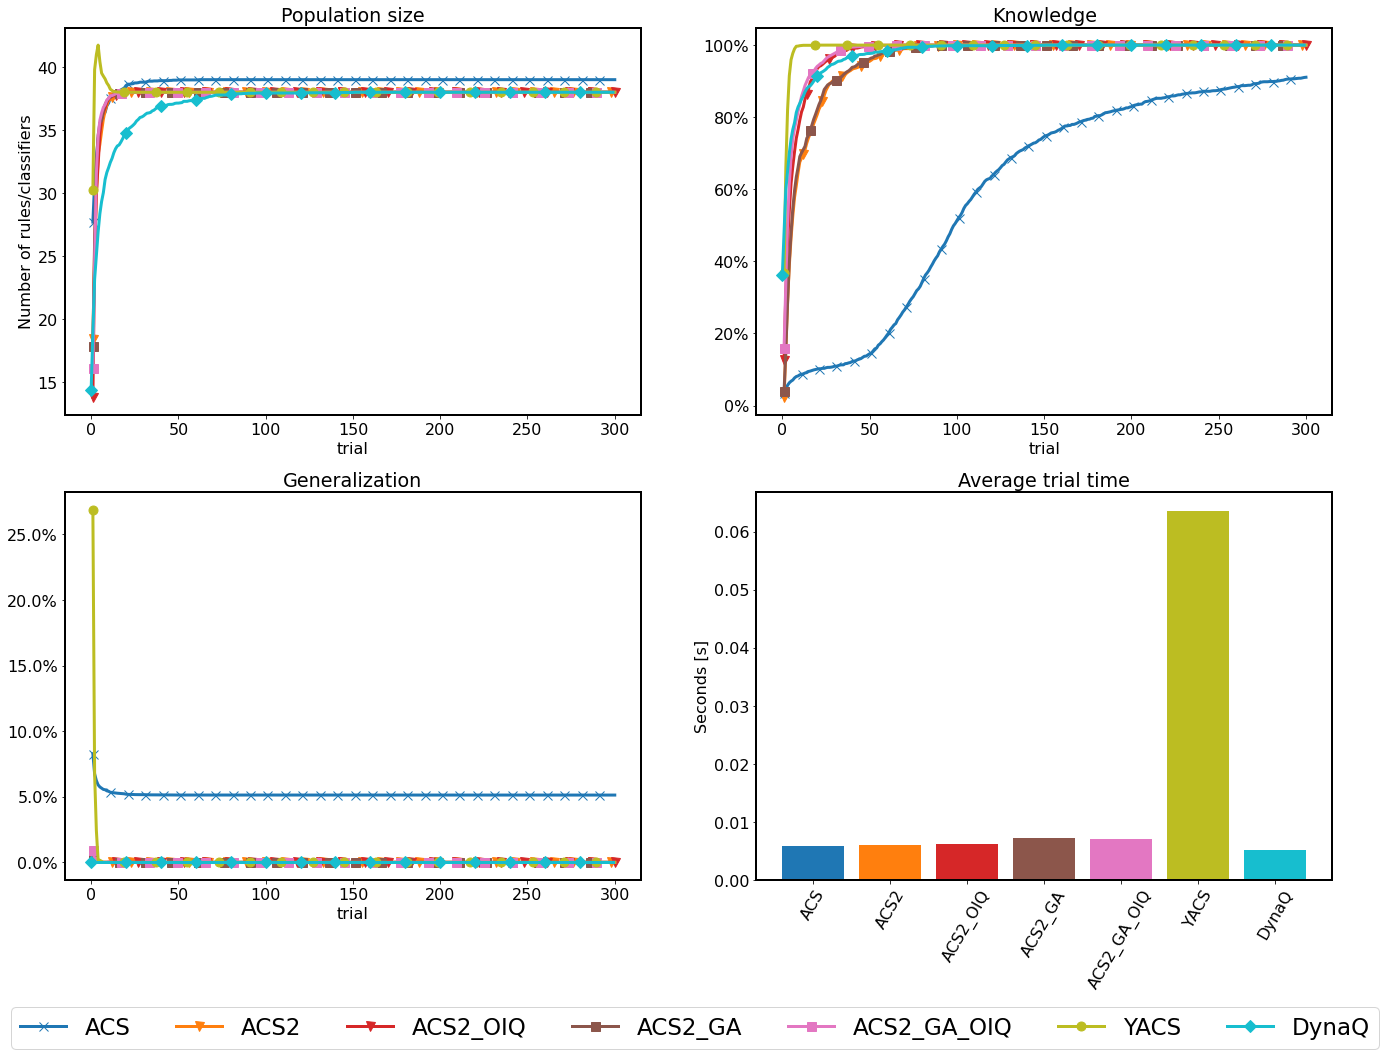

In [12]:
%run utils/plotting.py

# average experiments
corridor_metrics_averaged_df = pd.concat(corridor_metrics).groupby(['agent', 'trial']).mean()

plot_comparison(corridor_metrics_averaged_df)
plt.savefig('plots/corridor.pdf', transparent=False, bbox_inches='tight')

## Grid
![grid](img/grid-env.png)

In [13]:
grid = gym.make('grid-20-v0')
grid._max_episode_steps = 250

grid_transitions = grid.env._transitions

unique_states = set()
for (s0, a, s1) in grid_transitions:
    unique_states.add(s0)
    unique_states.add(s1)

grid_state_mapping = {idx: s for idx, s in enumerate(unique_states)}


# LCS helpers
def grid_knowledge(population, env):
    transitions = env.env.get_transitions()
    reliable = [c for c in population if c.is_reliable()]
    nr_correct = 0

    for start, action, end in transitions:
        p0 = Perception([str(el) for el in start])
        p1 = Perception([str(el) for el in end])

        if any([True for cl in reliable if cl.predicts_successfully(p0, action, p1)]):
            nr_correct += 1

    return nr_correct / len(transitions)


def grid_metrics_collector(agent, env):
    population = agent.population
    return {
        'pop': len(population),
        'knowledge': grid_knowledge(population, env),
        'generalization': generalization_score(population)
    }


# DynaQ helpers
def grid_perception_to_int(p0):
    p0m = tuple(map(int, p0))
    return list(grid_state_mapping.keys())[list(grid_state_mapping.values()).index(p0m)]


def dynaq_grid_knowledge_calculator(model, env):
    all_transitions = 0
    nr_correct = 0

    for p0, a, p1 in grid_transitions:
        s0 = grid_perception_to_int(p0)
        s1 = grid_perception_to_int(p1)

        all_transitions += 1
        if s0 in model and a in model[s0] and model[s0][a][0] == s1:
            nr_correct += 1

    return nr_correct / all_transitions

In [14]:
%%time

common_params = {
    'env': grid,
    'observation_wrapper': None,
    'classifier_length': 2,
    'possible_actions': 4,
    'learning_rate': 0.1,
    'metrics_trial_freq': 1,
    'metrics_fcn': grid_metrics_collector,
    'trials': 250
}

yacs_params = {
    'trace_length': 3,
    'estimate_expected_improvements': False,
    'feature_possible_values': [
        set(str(i) for i in range(20)),
        set(str(i) for i in range(20))
    ]
}

dynaq_params = {
    'q_init': np.zeros((len(grid_state_mapping), 4)),
    'model_init': {},
    'perception_to_state_mapper': grid_perception_to_int,
    'knowledge_fcn': dynaq_grid_knowledge_calculator,
    'epsilon': 0.5,
}

grid_metrics = get_from_cache_or_run(
    f'{cache_prefix}/Grid4.dill',
    lambda: execute_experiments(lambda: run_experiment_parallel(common_params,
                                                                acs_params={},
                                                                acs2_params={'do_ga': False, 'initial_q': 0.5},
                                                                acs2_oiq_params={'do_ga': False, 'initial_q': 0.8},
                                                                acs2_ga_params={'do_ga': True, 'initial_q': 0.5},
                                                                acs2_ga_oiq_params={'do_ga': True, 'initial_q': 0.8},
                                                                yacs_params=yacs_params,
                                                                dynaq_params=dynaq_params),
                                n=50))


CPU times: user 91 ms, sys: 3.31 ms, total: 94.3 ms
Wall time: 94.4 ms


/home/arc/Projects/pwr/pyalcs-experiments/notebooks/publications/latent-learning-for-anticipatory-classifier-systems-in-discretized-real-valued-environments/utils/plotting.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 1].set_xticklabels(labels, rotation=60)


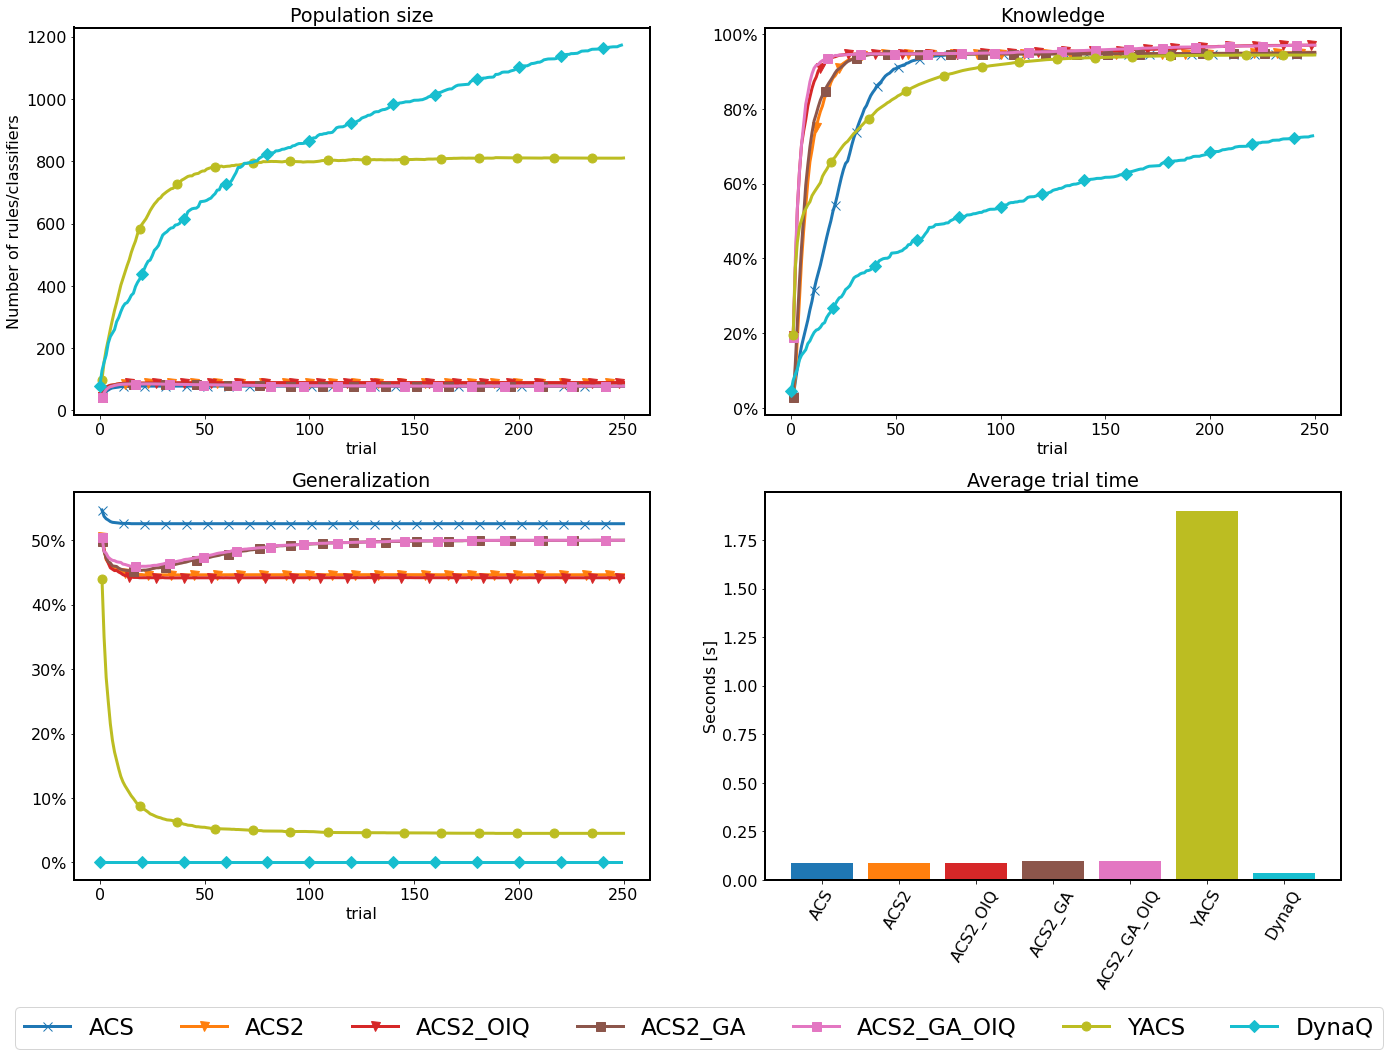

In [15]:
%run utils/plotting.py

# average experiments
grid_metrics_averaged_df = pd.concat(grid_metrics).groupby(['agent', 'trial']).mean()

plot_comparison(grid_metrics_averaged_df)
plt.savefig('plots/grid.pdf', transparent=False, bbox_inches='tight')

### Grid classifier comparison
Evaluate some LCS and examine how the population of classifier looks like for a certain state.

In [16]:
def print_cls_comparison(perception, common_params, acs_params={}, acs2_params={}, yacs_params={}):
    def evaluate(common_params, acs_params={}, acs2_params={}, yacs_params={}):
        common_params['explore_trials'] = 25
        result = dict()

        run_acs(result, 'acs', **{**common_params, **acs_params})
        run_acs2(result, 'acs2', **{**common_params, **acs2_params, **{'do_ga': False, 'initial_q': 0.5}})
        run_yacs(result, 'yacs', **{**common_params, **yacs_params})

        return result

    def print_cl(cl):
        moves = ['←', '→', '↑', '↓']
        return f"{cl.condition} {moves[cl.action]} {cl.effect}"

    # cache function above
    grid_cls_comparison = get_from_cache_or_run(
        f'{cache_prefix}/Grid-classifiers.dill',
        lambda: evaluate(common_params, yacs_params=yacs_params))

    # compare algorithms
    print('\nACS Population')
    for cl in sorted(grid_cls_comparison['acs'][0].form_match_set(perception), key=lambda cl: cl.action):
        print(f"{print_cl(cl)}")

    print('\nACS2 Population')
    for cl in sorted(grid_cls_comparison['acs2'][0].form_match_set(perception), key=lambda cl: cl.action):
        print(f"{print_cl(cl)}")

    print('\nYACS Population')
    for cl in sorted(grid_cls_comparison['yacs'][0].form_match_set(perception), key=lambda cl: cl.action):
        print(f"{print_cl(cl)}")


print_cls_comparison(Perception(('18', '19')), common_params, yacs_params=yacs_params)


ACS Population
## ← ##
18# ← 17#
## → ##
18# → 19#
## ↑ ##
## ↓ ##
#19 ↓ #18

ACS2 Population
18# ← 17#
18# → 19#
#19 ↑ ##
#19 ↓ #18

YACS Population
1819 ← 3#
1819 ← 17#
1819 → 7#
1819 → 19#
#19 ↑ ##
1819 ↓ #18


## rMPX

In [17]:
RMPX_SIZE = 3
CTRL_BITS = 1

RMPX_BINS = 10

rmpx = gym.make(f'real-multiplexer-{RMPX_SIZE}bit-v0')

_range, _low = (rmpx.observation_space.high - rmpx.observation_space.low, rmpx.observation_space.low)

RMPX_STEP = _range / RMPX_BINS

In [18]:
import itertools
import bitstring


class RealMultiplexerUtils:
    def __init__(self, size, ctrl_bits, bins, _range, _threshold=0.5):
        self._size = size
        self._ctrl_bits = ctrl_bits
        self._bins = bins
        self._step = _range / bins
        self._threshold = _threshold

        self._attribute_values = [list(range(0, bins))] * (size) + [[0, bins]]
        self._input_space = itertools.product(*self._attribute_values)
        self.state_mapping = {idx: s for idx, s in enumerate(self._input_space)}
        self.state_mapping_inv = {v: k for k, v in self.state_mapping.items()}

    def discretize(self, obs, _type=int):
        r = (obs + np.abs(_low)) / _range
        b = (r * RMPX_BINS).astype(int)
        return b.astype(_type).tolist()

    def reverse_discretize(self, discretized):
        return discretized * self._step[:len(discretized)]

    def get_transitions(self):
        transitions = []

        initial_dstates = [list(range(0, self._bins))] * (self._size)
        for d_state in itertools.product(*initial_dstates):
            correct_answer = self._get_correct_answer(d_state)

            if correct_answer == 0:
                transitions.append((d_state + (0,), 0, d_state + (self._bins,)))
                transitions.append((d_state + (0,), 1, d_state + (0,)))
            else:
                transitions.append((d_state + (0,), 0, d_state + (0,)))
                transitions.append((d_state + (0,), 1, d_state + (self._bins,)))

        return transitions

    def _get_correct_answer(self, discretized):
        estimated_obs = self.reverse_discretize(discretized)
        # B = np.where(estimated_obs > self._threshold, 1, 0)
        bits = bitstring.BitArray(estimated_obs > self._threshold)
        _ctrl_bits = bits[:self._ctrl_bits]
        _data_bits = bits[self._ctrl_bits:]

        return int(_data_bits[_ctrl_bits.uint])

In [19]:
rmpx_utils = RealMultiplexerUtils(RMPX_SIZE, CTRL_BITS, RMPX_BINS, _range)
print(f"Possible states: {len(rmpx_utils.state_mapping)}")


class DiscretizedWrapper(gym.ObservationWrapper):
    def observation(self, obs):
        return rmpx_utils.discretize(obs, _type=str)


def rmpx_knowledge(population, env):
    reliable = [c for c in population if c.is_reliable()]
    nr_correct = 0

    for start, action, end in rmpx_utils.get_transitions():
        p0 = Perception([str(el) for el in start])
        p1 = Perception([str(el) for el in end])

        if any([True for cl in reliable if cl.predicts_successfully(p0, action, p1)]):
            nr_correct += 1

    return nr_correct / len(rmpx_utils.get_transitions())


def rmpx_metrics_collector(agent, env):
    population = agent.population
    return {
        'pop': len(population),
        'knowledge': rmpx_knowledge(population, env),
        'generalization': generalization_score(population)
    }


# DynaQ helpers
def rmpx_perception_to_int(p0, discretize=True):
    if discretize:
        p0 = rmpx_utils.discretize(p0)

    return rmpx_utils.state_mapping_inv[tuple(p0)]


def dynaq_rmpx_knowledge_calculator(model, env):
    all_transitions = 0
    nr_correct = 0

    for p0, a, p1 in rmpx_utils.get_transitions():
        s0 = rmpx_perception_to_int(p0, discretize=False)
        s1 = rmpx_perception_to_int(p1, discretize=False)

        all_transitions += 1
        if s0 in model and a in model[s0] and model[s0][a][0] == s1:
            nr_correct += 1

    return nr_correct / len(rmpx_utils.get_transitions())

Possible states: 2000


Knowledge calculation (creating transition matrix):
1. Generate all posible discretized states (with `0` at the end)
2. For each such a state estimate original perception (multiply by step size)
3. For each estimated perception obtain correct answer
4. For each estimate perception create two rows in transition matrix - for good and wrong answer. 


In [20]:
%%time

common_params = {
    'env': rmpx,
    'observation_wrapper': DiscretizedWrapper,
    'classifier_length': RMPX_SIZE+1,
    'possible_actions': 2,
    'learning_rate': 0.1,
    'metrics_trial_freq': 100,
    'metrics_fcn': rmpx_metrics_collector,
    'trials': 15_000
}

yacs_params = {
    'trace_length': 3,
    'estimate_expected_improvements': False,
    'feature_possible_values': [{str(i) for i in range(RMPX_BINS)}] * RMPX_SIZE + [{'0', '10'}]
}

dynaq_params = {
    'q_init': np.zeros((len(rmpx_utils.state_mapping), 2)),
    'model_init': {},
    'perception_to_state_mapper': rmpx_perception_to_int,
    'knowledge_fcn': dynaq_rmpx_knowledge_calculator,
    'epsilon': 0.5
}

rmpx_metrics = get_from_cache_or_run(
    f'{cache_prefix}/rmpx10.dill',
    lambda: execute_experiments(lambda: run_experiment_parallel(common_params,
                                                                acs_params={},
                                                                acs2_params={'do_ga': False, 'initial_q': 0.5},
                                                                acs2_oiq_params={'do_ga': False, 'initial_q': 0.8},
                                                                acs2_ga_params={'do_ga': True, 'initial_q': 0.5},
                                                                acs2_ga_oiq_params={'do_ga': True, 'initial_q': 0.8},
                                                                yacs_params=yacs_params,
                                                                dynaq_params=dynaq_params),
                                n=50))

CPU times: user 31.5 ms, sys: 0 ns, total: 31.5 ms
Wall time: 30.7 ms


/home/arc/Projects/pwr/pyalcs-experiments/notebooks/publications/latent-learning-for-anticipatory-classifier-systems-in-discretized-real-valued-environments/utils/plotting.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 1].set_xticklabels(labels, rotation=60)


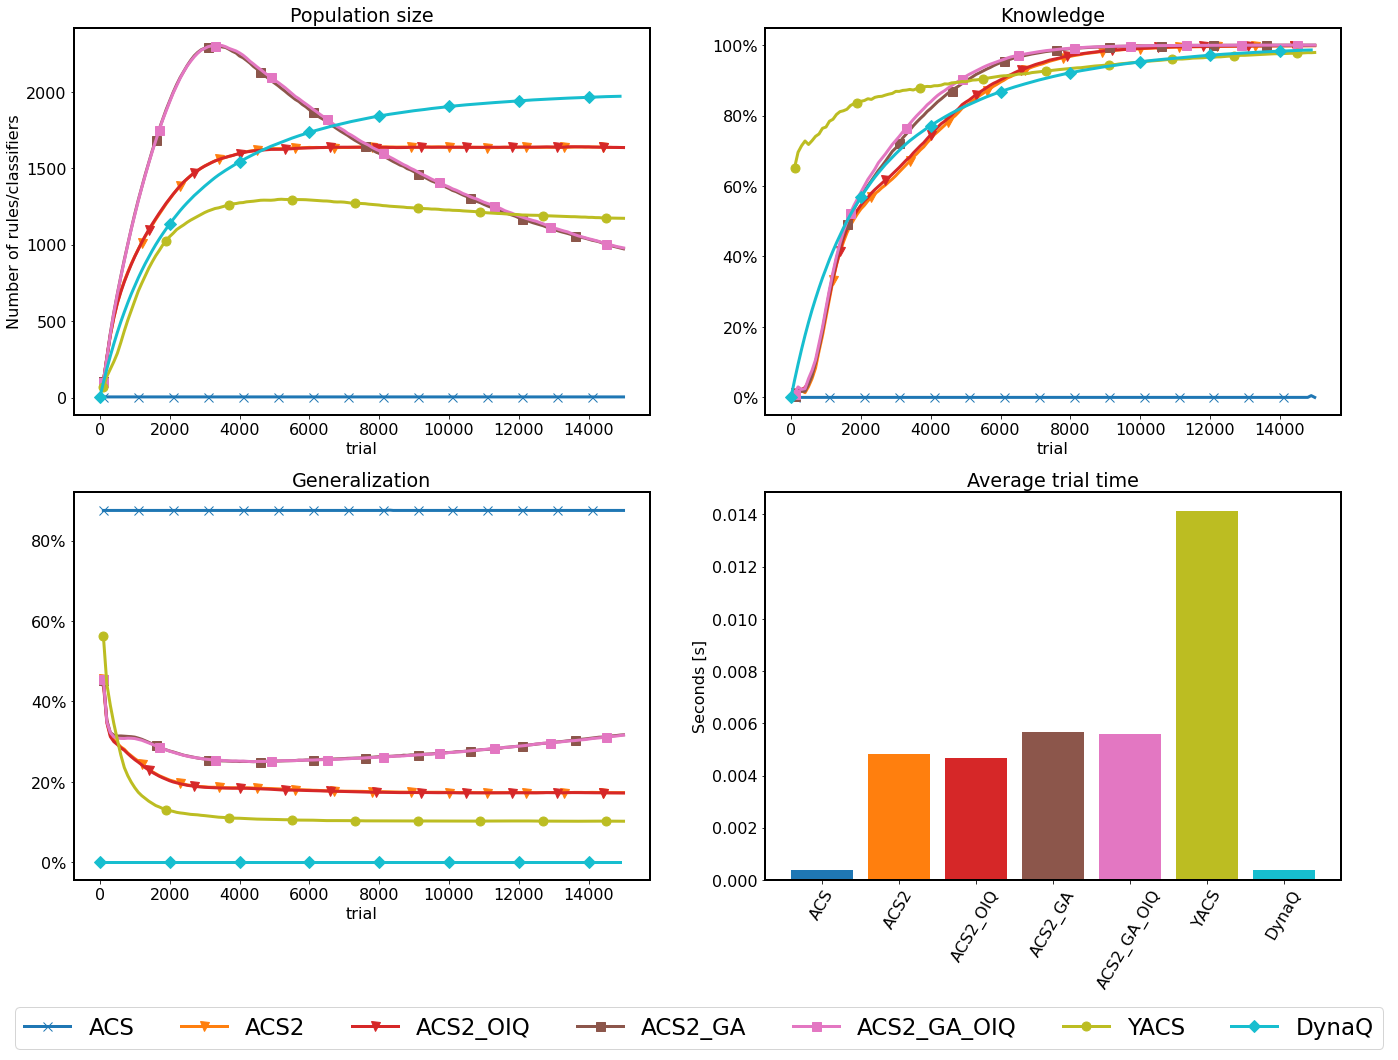

In [21]:
%run utils/plotting.py

# average experiments
rmpx_metrics_averaged_df = pd.concat(rmpx_metrics).groupby(['agent', 'trial']).mean()

plot_comparison(rmpx_metrics_averaged_df)
plt.savefig('plots/rmpx.pdf', transparent=False, bbox_inches='tight')

# Statistical analysis

## Is collected data normally distributed?
Perform statistical tests to determine whether collected data follow the normal distribution. Last collected metric in experiment is considered.


In [22]:
import warnings
warnings.filterwarnings('ignore')

def analyze_metrics_for_normality(df):
    normality_results = {}

    for metric in metrics:
        normality_results[metric] = {}

        for agent in agents:
            normality_results[metric][agent] = {}

            # pick up last metric
            agent_metrics = pd.concat(df).loc[agent]
            x = agent_metrics.loc[agent_metrics.index.max()][metric].to_list()

            # check if any of normality tests yields true
            normality_results[metric][agent] = any(check_normality(x))

    return normality_results

In [23]:
pd.DataFrame(analyze_metrics_for_normality(simple_maze_metrics))

,knowledge,generalization,population,time
acs,False,True,False,False
acs2,True,True,False,True
acs2_oiq,True,True,True,False
acs2_ga,True,True,True,False
acs2_ga_oiq,True,True,True,False
yacs,False,True,True,False
dynaq,True,True,True,True


In [24]:
pd.DataFrame(analyze_metrics_for_normality(corridor_metrics))

,knowledge,generalization,population,time
acs,True,True,True,True
acs2,True,True,True,False
acs2_oiq,True,True,True,False
acs2_ga,True,True,True,False
acs2_ga_oiq,True,True,True,True
yacs,True,True,True,False
dynaq,True,True,True,True


In [25]:
pd.DataFrame(analyze_metrics_for_normality(grid_metrics))

,knowledge,generalization,population,time
acs,True,True,True,False
acs2,False,True,True,False
acs2_oiq,False,False,True,True
acs2_ga,False,True,True,False
acs2_ga_oiq,False,False,False,True
yacs,True,False,True,True
dynaq,False,True,False,False


In [26]:
pd.DataFrame(analyze_metrics_for_normality(rmpx_metrics))

,knowledge,generalization,population,time
acs,True,True,True,False
acs2,False,True,True,False
acs2_oiq,False,True,True,False
acs2_ga,False,True,True,False
acs2_ga_oiq,False,True,True,False
yacs,False,True,True,False
dynaq,True,True,True,False


## Non-parametric comparison

Performs Mann Whitney non-parametric test to determine whether data in both groups is from the same distribution.

In [27]:
def non_parametric(df):
    result = []

    for model_1, model_2 in itertools.permutations(agents, 2):
        model_1_data = pd.concat(df).loc[model_1]
        model_2_data = pd.concat(df).loc[model_2]


        same_metric_distributions = []
        for metric in metrics:
            same_dis = mann_whitney_test(
                model_1_data.loc[model_1_data.index.max()][metric].to_list(),
                model_2_data.loc[model_2_data.index.max()][metric].to_list()
            )

            if same_dis[0]:
                same_metric_distributions.append(metric)

        result.append({
            'model_1': model_1,
            'model_2': model_2,
            'same_metric_distribution': same_metric_distributions
        })

    return result

In [28]:
pd.DataFrame(non_parametric(simple_maze_metrics)).pivot(index='model_1', columns='model_2', values='same_metric_distribution')

model_2,acs,acs2,acs2_ga,acs2_ga_oiq,acs2_oiq,dynaq,yacs
model_1,,,,,,,
acs,NaN,[time],[],[],[time],[],[]
acs2,[time],NaN,[knowledge],[knowledge],"[knowledge, generalization, population, time]",[knowledge],[]
acs2_ga,[],[knowledge],NaN,"[knowledge, population]",[knowledge],[knowledge],[]
acs2_ga_oiq,[],[knowledge],"[knowledge, population]",NaN,[knowledge],[knowledge],[]
acs2_oiq,[time],"[knowledge, generalization, population, time]",[knowledge],[knowledge],NaN,[knowledge],[]
dynaq,[],[knowledge],[knowledge],[knowledge],[knowledge],NaN,[]
yacs,[],[],[],[],[],[],NaN


In [29]:
pd.DataFrame(non_parametric(corridor_metrics)).pivot(index='model_1', columns='model_2', values='same_metric_distribution')

model_2,acs,acs2,acs2_ga,acs2_ga_oiq,acs2_oiq,dynaq,yacs
model_1,,,,,,,
acs,NaN,[],[],[],[],[],[]
acs2,[],NaN,"[knowledge, generalization, population, time]","[knowledge, generalization, population, time]","[knowledge, generalization, population, time]","[knowledge, generalization, population]","[knowledge, generalization, population]"
acs2_ga,[],"[knowledge, generalization, population, time]",NaN,"[knowledge, generalization, population, time]","[knowledge, generalization, population, time]","[knowledge, generalization, population]","[knowledge, generalization, population]"
acs2_ga_oiq,[],"[knowledge, generalization, population, time]","[knowledge, generalization, population, time]",NaN,"[knowledge, generalization, population, time]","[knowledge, generalization, population]","[knowledge, generalization, population]"
acs2_oiq,[],"[knowledge, generalization, population, time]","[knowledge, generalization, population, time]","[knowledge, generalization, population, time]",NaN,"[knowledge, generalization, population]","[knowledge, generalization, population]"
dynaq,[],"[knowledge, generalization, population]","[knowledge, generalization, population]","[knowledge, generalization, population]","[knowledge, generalization, population]",NaN,"[knowledge, generalization, population]"
yacs,[],"[knowledge, generalization, population]","[knowledge, generalization, population]","[knowledge, generalization, population]","[knowledge, generalization, population]","[knowledge, generalization, population]",NaN


In [30]:
pd.DataFrame(non_parametric(grid_metrics)).pivot(index='model_1', columns='model_2', values='same_metric_distribution')

model_2,acs,acs2,acs2_ga,acs2_ga_oiq,acs2_oiq,dynaq,yacs
model_1,,,,,,,
acs,NaN,[],"[population, time]","[population, time]",[],[],[knowledge]
acs2,[],NaN,[knowledge],[],"[generalization, population, time]",[],[knowledge]
acs2_ga,"[population, time]",[knowledge],NaN,"[generalization, population, time]",[],[],[knowledge]
acs2_ga_oiq,"[population, time]",[],"[generalization, population, time]",NaN,[knowledge],[],[]
acs2_oiq,[],"[generalization, population, time]",[],[knowledge],NaN,[],[]
dynaq,[],[],[],[],[],NaN,[]
yacs,[knowledge],[knowledge],[knowledge],[],[],[],NaN


In [31]:
pd.DataFrame(non_parametric(rmpx_metrics)).pivot(index='model_1', columns='model_2', values='same_metric_distribution')

model_2,acs,acs2,acs2_ga,acs2_ga_oiq,acs2_oiq,dynaq,yacs
model_1,,,,,,,
acs,NaN,[],[],[],[],[time],[]
acs2,[],NaN,[],[],"[knowledge, generalization, population, time]",[],[]
acs2_ga,[],[],NaN,"[knowledge, generalization, population, time]",[],[],[]
acs2_ga_oiq,[],[],"[knowledge, generalization, population, time]",NaN,[],[],[]
acs2_oiq,[],"[knowledge, generalization, population, time]",[],[],NaN,[],[]
dynaq,[time],[],[],[],[],NaN,[]
yacs,[],[],[],[],[],[],NaN


## Bayes Estimation

In [32]:
def all_values_the_same(s: pd.Series):
    a = s.to_numpy()
    return (a[0] == a).all()

def bayes_estimate_mean(df):
    """Returns mean and standard deviation of performed Bayesian Estimation"""
    est_means = {}
    merged_df = pd.concat(df)

    for agent in agents:
        est_means[agent] = {}
        max_idx = merged_df.loc[agent].index.max()

        for metric in metrics:
            last_trial_data = merged_df.loc[agent].loc[max_idx][metric]
            if all_values_the_same(last_trial_data):
                est_trial_data = {
                    'mu': last_trial_data.mean(),
                    'std': last_trial_data.std(),
                }
            else:
                be = bayes_estimate(last_trial_data)
                est_trial_data = {
                    'mu': be['mu'].mean(),
                    'std': be['mu'].std()
                }

            est_means[agent][metric] = est_trial_data

    return est_means

def extract_stats(bayes_estimation_result):
    means = {}
    stds = {}

    for alg, v in bayes_estimation_result.items():
        means[alg] = {}
        stds[alg] = {}

        for metric, stats in v.items():
            means[alg][metric] = stats['mu']
            stds[alg][metric] = stats['std']

    return means, stds

In [33]:
simple_maze_bayes_estimation = get_from_cache_or_run(
    f'{cache_prefix}/SimpleMaze-bayes.dill',
    lambda: bayes_estimate_mean(simple_maze_metrics))

simple_maze_m, simple_maze_s = extract_stats(simple_maze_bayes_estimation)
simple_maze_bayes_df = pd.DataFrame(simple_maze_m).T
simple_maze_bayes_df.attrs['name'] = 'Simple Maze'
simple_maze_bayes_df.round(3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, std, mu]
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 6 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, std, mu]
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 7 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, std, mu]
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 6 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, std, mu]
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 8 seconds.
Auto-assigning NUTS sampler.

,knowledge,generalization,population,time
acs,0.965,0.510,21.310,0.005
acs2,1.000,0.329,30.873,0.004
acs2_oiq,1.000,0.327,31.409,0.004
acs2_ga,1.000,0.450,53.333,0.009
acs2_ga_oiq,1.000,0.463,51.730,0.012
yacs,1.000,0.265,26.474,0.039
dynaq,1.000,0.000,32.000,0.002


In [34]:
corridor_bayes_estimation = get_from_cache_or_run(
    f'{cache_prefix}/Corridor-bayes.dill',
    lambda: bayes_estimate_mean(corridor_metrics))

corridor_m, corridor_s = extract_stats(corridor_bayes_estimation)
corridor_bayes_df = pd.DataFrame(corridor_m).T
corridor_bayes_df.attrs['name'] = 'Corridor'
corridor_bayes_df.round(3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, std, mu]
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, std, mu]
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 8 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, std, mu]
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 7 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, std, mu]
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 8 seconds.
Auto-assigning NUTS sampler.

,knowledge,generalization,population,time
acs,0.911,0.051,39.0,0.006
acs2,1.000,0.000,38.0,0.003
acs2_oiq,1.000,0.000,38.0,0.004
acs2_ga,1.000,0.000,38.0,0.003
acs2_ga_oiq,1.000,0.000,38.0,0.004
yacs,1.000,0.000,38.0,0.063
dynaq,1.000,0.000,38.0,0.002


In [35]:
grid_bayes_estimation = get_from_cache_or_run(
    f'{cache_prefix}/Grid-bayes.dill',
    lambda: bayes_estimate_mean(grid_metrics))

grid_m, grid_s = extract_stats(grid_bayes_estimation)
grid_bayes_df = pd.DataFrame(grid_m).T
grid_bayes_df.attrs['name'] = 'Grid'
grid_bayes_df.round(3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, std, mu]
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 6 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, std, mu]
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 7 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, std, mu]
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 6 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, std, mu]
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler.

,knowledge,generalization,population,time
acs,0.947,0.526,78.000,0.081
acs2,0.951,0.446,87.867,0.061
acs2_oiq,0.971,0.442,89.104,0.061
acs2_ga,0.951,0.500,78.000,0.071
acs2_ga_oiq,0.971,0.500,78.000,0.071
yacs,0.944,0.032,804.475,1.999
dynaq,0.727,0.000,1171.178,0.037


In [36]:
rmpx_bayes_estimation = get_from_cache_or_run(
    f'{cache_prefix}/rmpx-bayes.dill',
    lambda: bayes_estimate_mean(rmpx_metrics))

rmpx_m, rmpx_s = extract_stats(rmpx_bayes_estimation)
rmpx_bayes_df = pd.DataFrame(rmpx_m).T
rmpx_bayes_df.attrs['name'] = 'rMPX'
rmpx_bayes_df.round(3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, std, mu]
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, std, mu]
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 8 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, std, mu]
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 9 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, std, mu]
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 6 seconds.
Auto-assigning NUTS sampler

,knowledge,generalization,population,time
acs,0.000,0.875,4.000,0.000
acs2,0.998,0.173,1636.243,0.004
acs2_oiq,0.999,0.172,1634.601,0.004
acs2_ga,1.000,0.317,973.388,0.003
acs2_ga_oiq,1.000,0.316,979.406,0.003
yacs,0.979,0.103,1168.872,0.014
dynaq,0.986,0.000,1972.310,0.000


### Radar plot

In [37]:
def normalize(df: pd.DataFrame, norm_type: str = 'max'):
    if norm_type == 'min-max':
        return (df-df.min()) / (df.max()-df.min())
    elif norm_type == 'mean':
        return (df-df.mean()) / df.std()
    elif norm_type == 'max':
        assert all(v >= 0 for v in df.min())
        return df / df.max()
    else:
        raise ValueError(f'Unknown normalization type: {norm_type}')

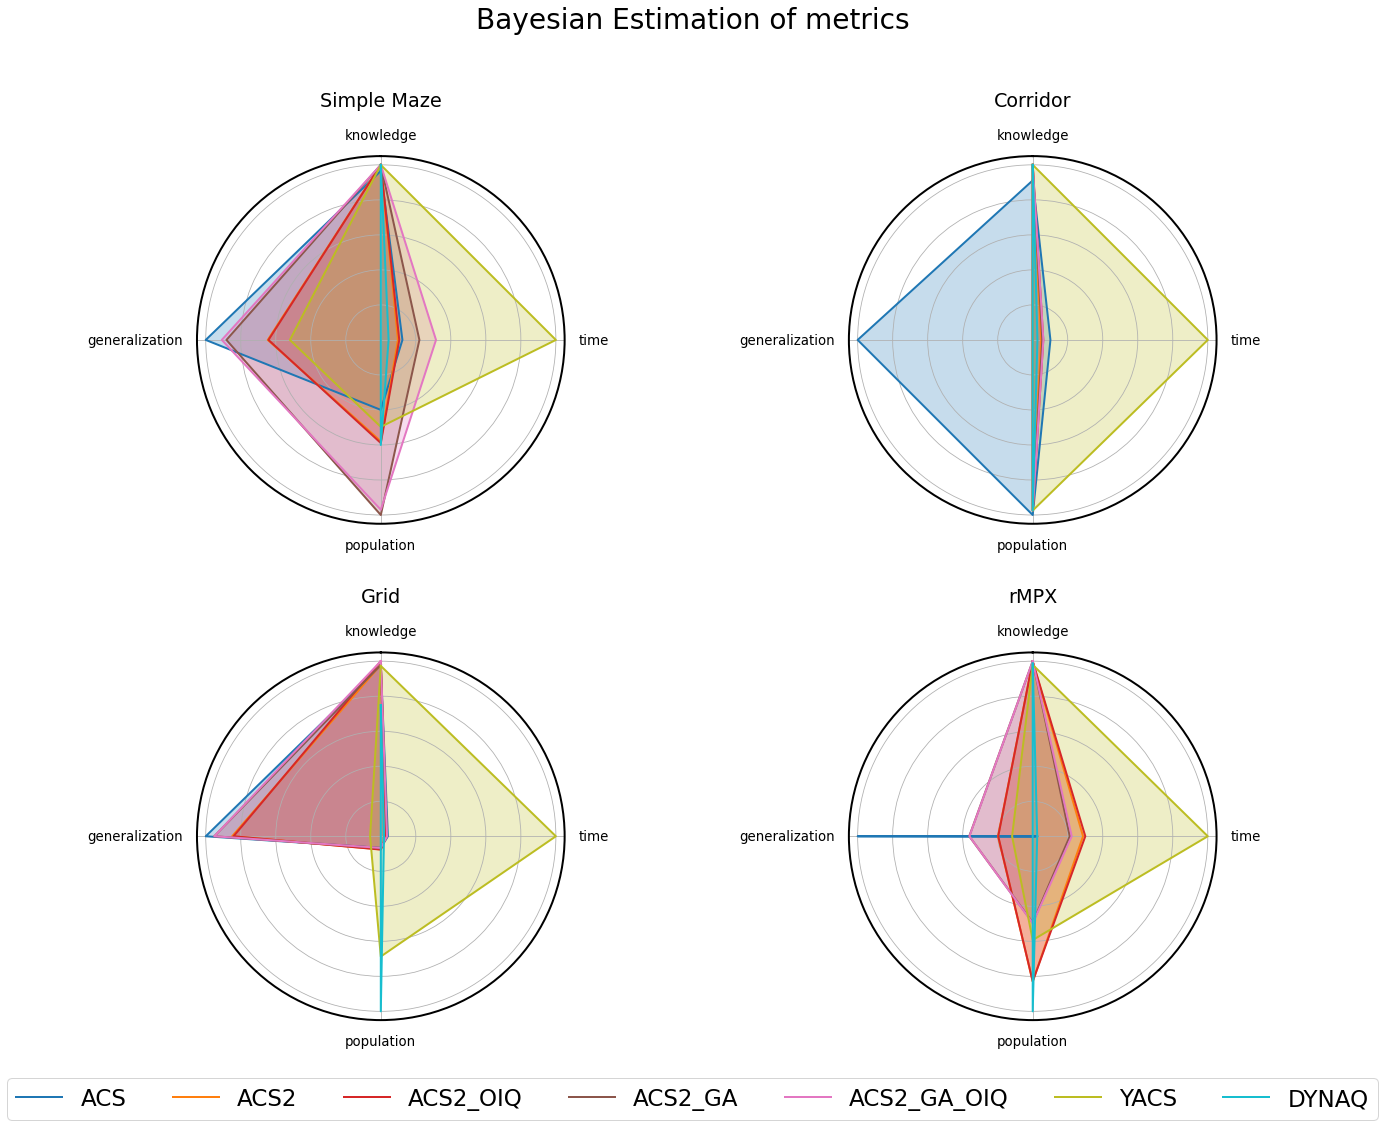

In [38]:
%run utils/plotting.py

# Normalize values and preserve attributes in dataframes
dfs = []
for df in [simple_maze_bayes_df, corridor_bayes_df, grid_bayes_df, rmpx_bayes_df]:
    normalized_df = normalize(df.copy())
    normalized_df.attrs = df.attrs
    dfs.append(normalized_df)

# Plot comparison
plot_bayes_comparison(*dfs)
plt.savefig('plots/bayes-estimation.pdf', transparent=False, bbox_inches='tight')